## Initial data analysis

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")
# Path to the data
data_path = "./data/ClimateTrain.csv"

# Read as pandas dataframe and transform dates to datetime
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

# Plot description
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


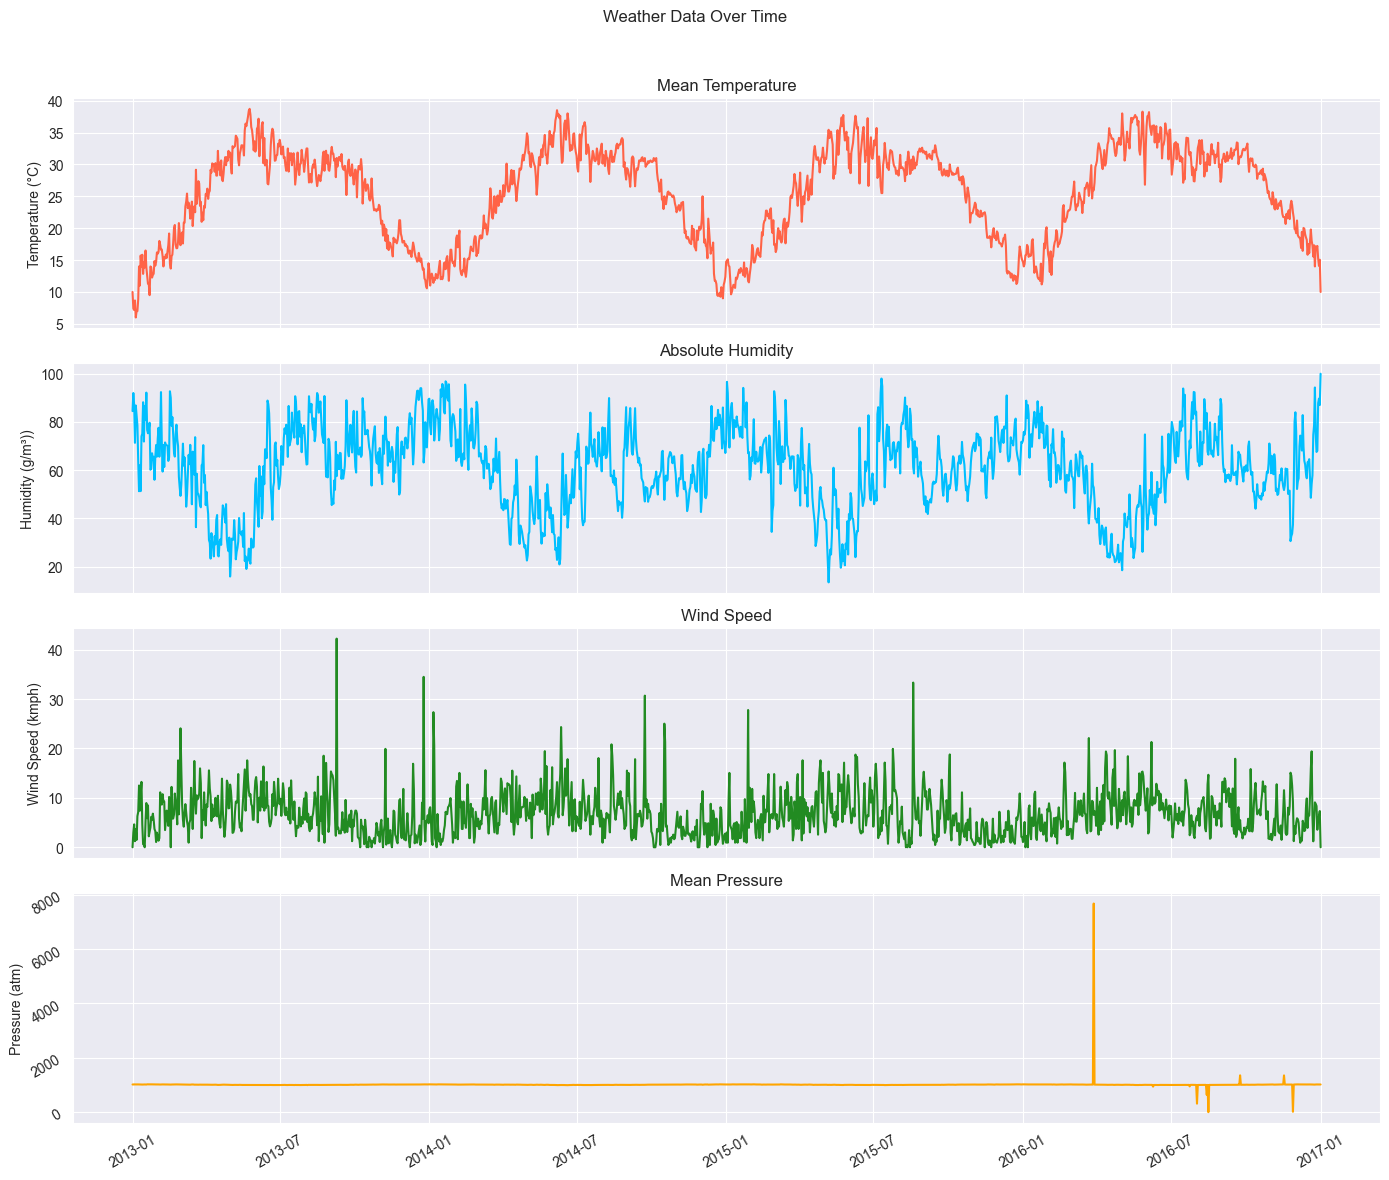

In [142]:

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)  # 4 rows, 1 column
fig.suptitle("Weather Data Over Time")

# Plot each variable
axes[0].plot(df['date'], df['meantemp'], color="tomato")
axes[0].set_ylabel("Temperature (°C)")
axes[0].set_title("Mean Temperature")

axes[1].plot(df['date'], df['humidity'], color="deepskyblue")
axes[1].set_ylabel("Humidity (g/m³))")
axes[1].set_title("Absolute Humidity")

axes[2].plot(df['date'], df['wind_speed'], color="forestgreen")
axes[2].set_ylabel("Wind Speed (kmph)")
axes[2].set_title("Wind Speed")

axes[3].plot(df['date'], df['meanpressure'], color="orange")
axes[3].set_ylabel("Pressure (atm)")
axes[3].set_title("Mean Pressure")

# Set x-axis major ticks to show selective dates only
axes[3].tick_params(rotation=30)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
plt.show()

### Poor man's outlier handling

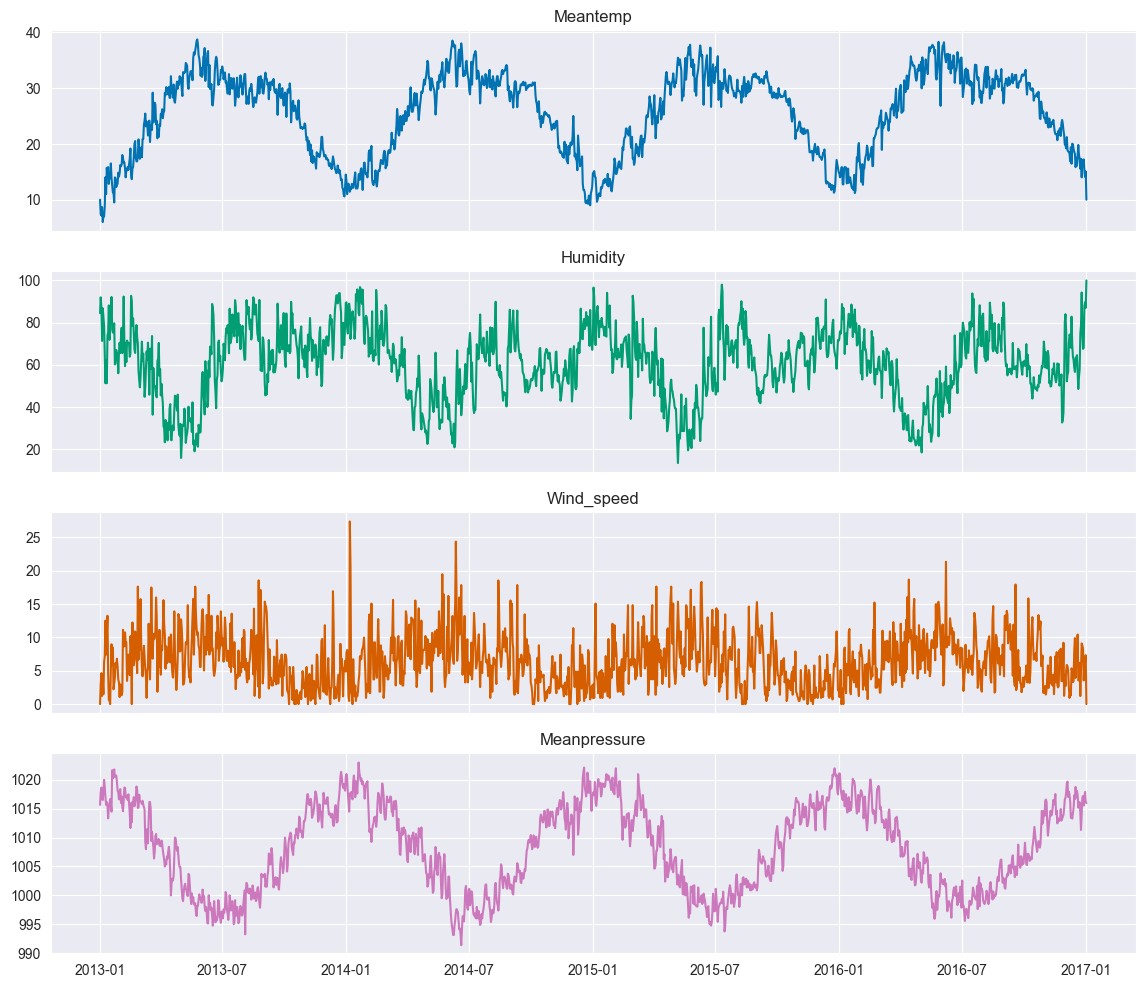

In [ ]:
figure, axes = plt.subplots(
    4, 1, figsize=(14, 12), sharex=True
)  # 4 rows, 1 column
for i, col in enumerate(df.columns[1:]):
    whole_period = df[col].dropna() # whole data
    normal_period = whole_period[: 2 * 365] # reference period (visually no major outliers here)
    
    roll = normal_period.rolling(window=30, min_periods=1, center=True) # Rolling window of 30 over the reference period
    roll_mean = roll.mean()
    roll_std = roll.std(ddof=0)

    mean = pd.concat([roll_mean, roll_mean], ignore_index=True) # Repeat for almost the whole period
    std = pd.concat([roll_std, roll_std], ignore_index=True) 

    z_score = (whole_period - mean) / std # Z-score based on the reference period
    out_bool = (z_score.abs() > 3) # Outliers are those with an absolute z-score greater than 3
    whole_period[out_bool] = mean[out_bool] # Replace outliers with the mean from the reference period

    axes[i].plot(df['date'], whole_period, color=colors[i])
    axes[i].set_title(col.capitalize())
    df[col] = whole_period

### Decomposition

In [144]:
decomps = []
for col in df.columns[1:]:
    column = df[col]
    column.index = df['date'] 
    decomps.append(
        sm.tsa.seasonal_decompose(column, model="additive", period=3*30)
    )

### Trend

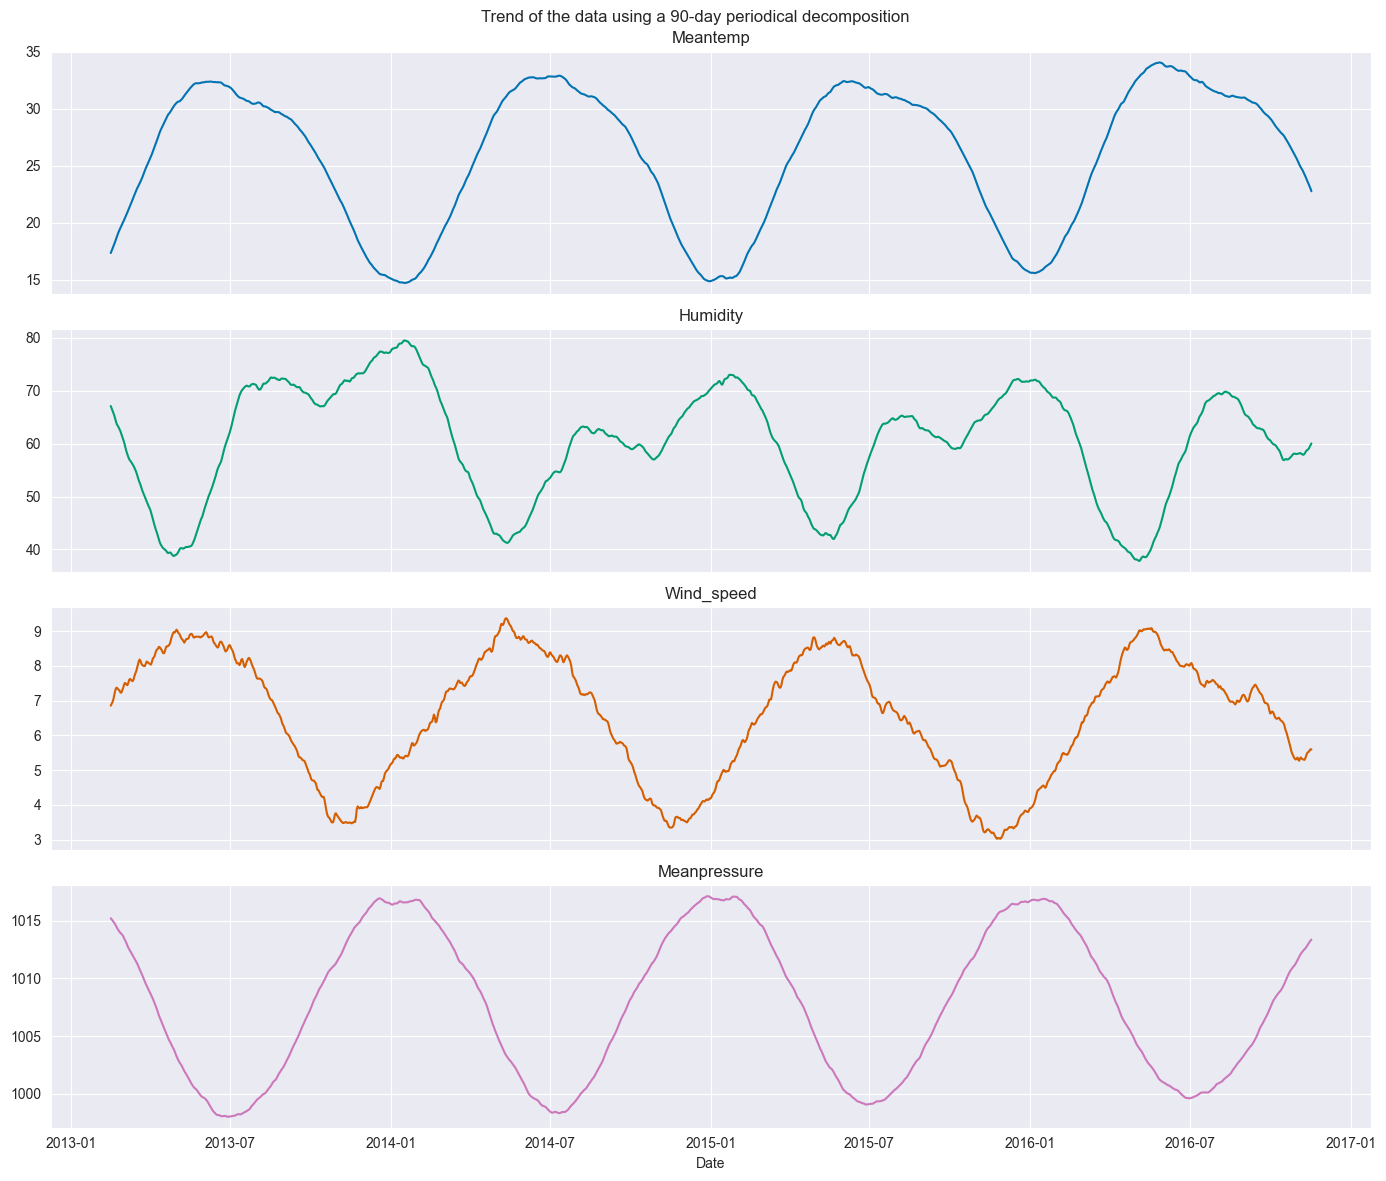

In [145]:
figure, axes = plt.subplots(len(decomps), 1, figsize=(14, 12), sharex=True)  # 4 rows, 1 column
for i, decomposition in enumerate(decomps):
    axes[i].plot(decomposition.trend, label='Trend', color=colors[i])
    axes[i].set_title(f"{df.columns[i+1].capitalize()}")
    
axes[-1].set_xlabel("Date")
figure.suptitle("Trend of the data using a 90-day periodical decomposition")
plt.tight_layout()
plt.show()

### Seasonality

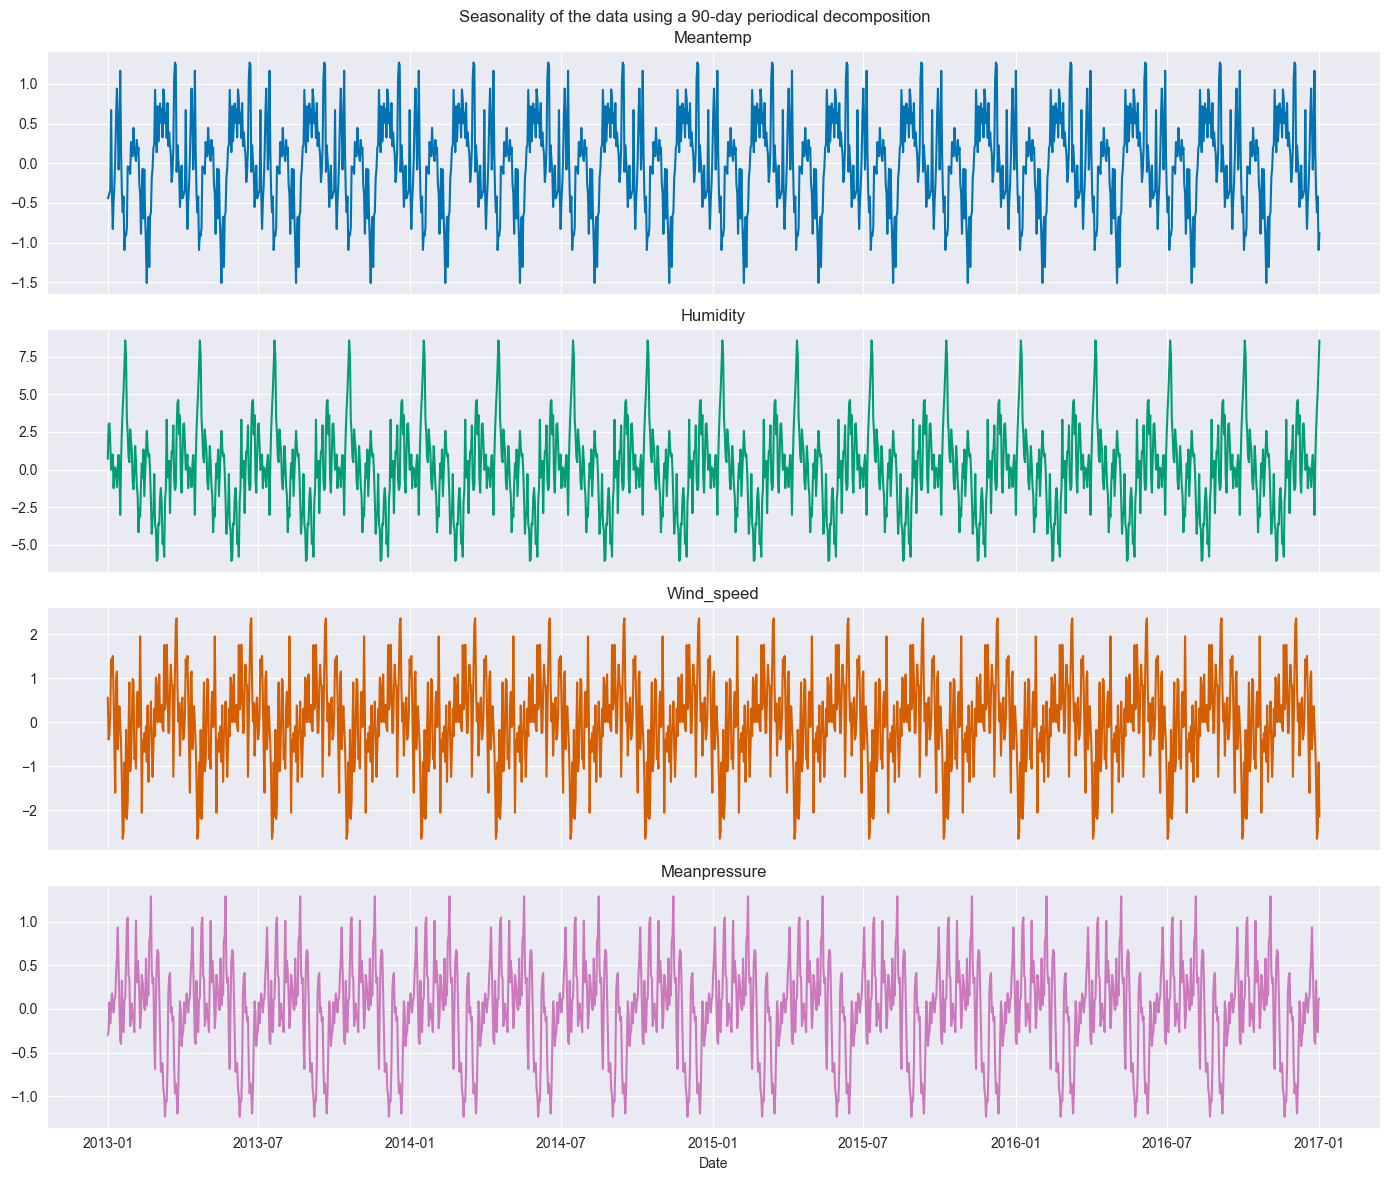

In [146]:
figure, axes = plt.subplots(
    len(decomps), 1, figsize=(14, 12), sharex=True
)  # 4 rows, 1 column
for i, decomposition in enumerate(decomps):
    seasonality = decomposition.seasonal
    axes[i].plot(seasonality, label="Trend", color=colors[i])
    axes[i].set_title(f"{df.columns[i+1].capitalize()}")

axes[-1].set_xlabel("Date")
figure.suptitle("Seasonality of the data using a 90-day periodical decomposition")
plt.tight_layout()
plt.show()

### Residuals

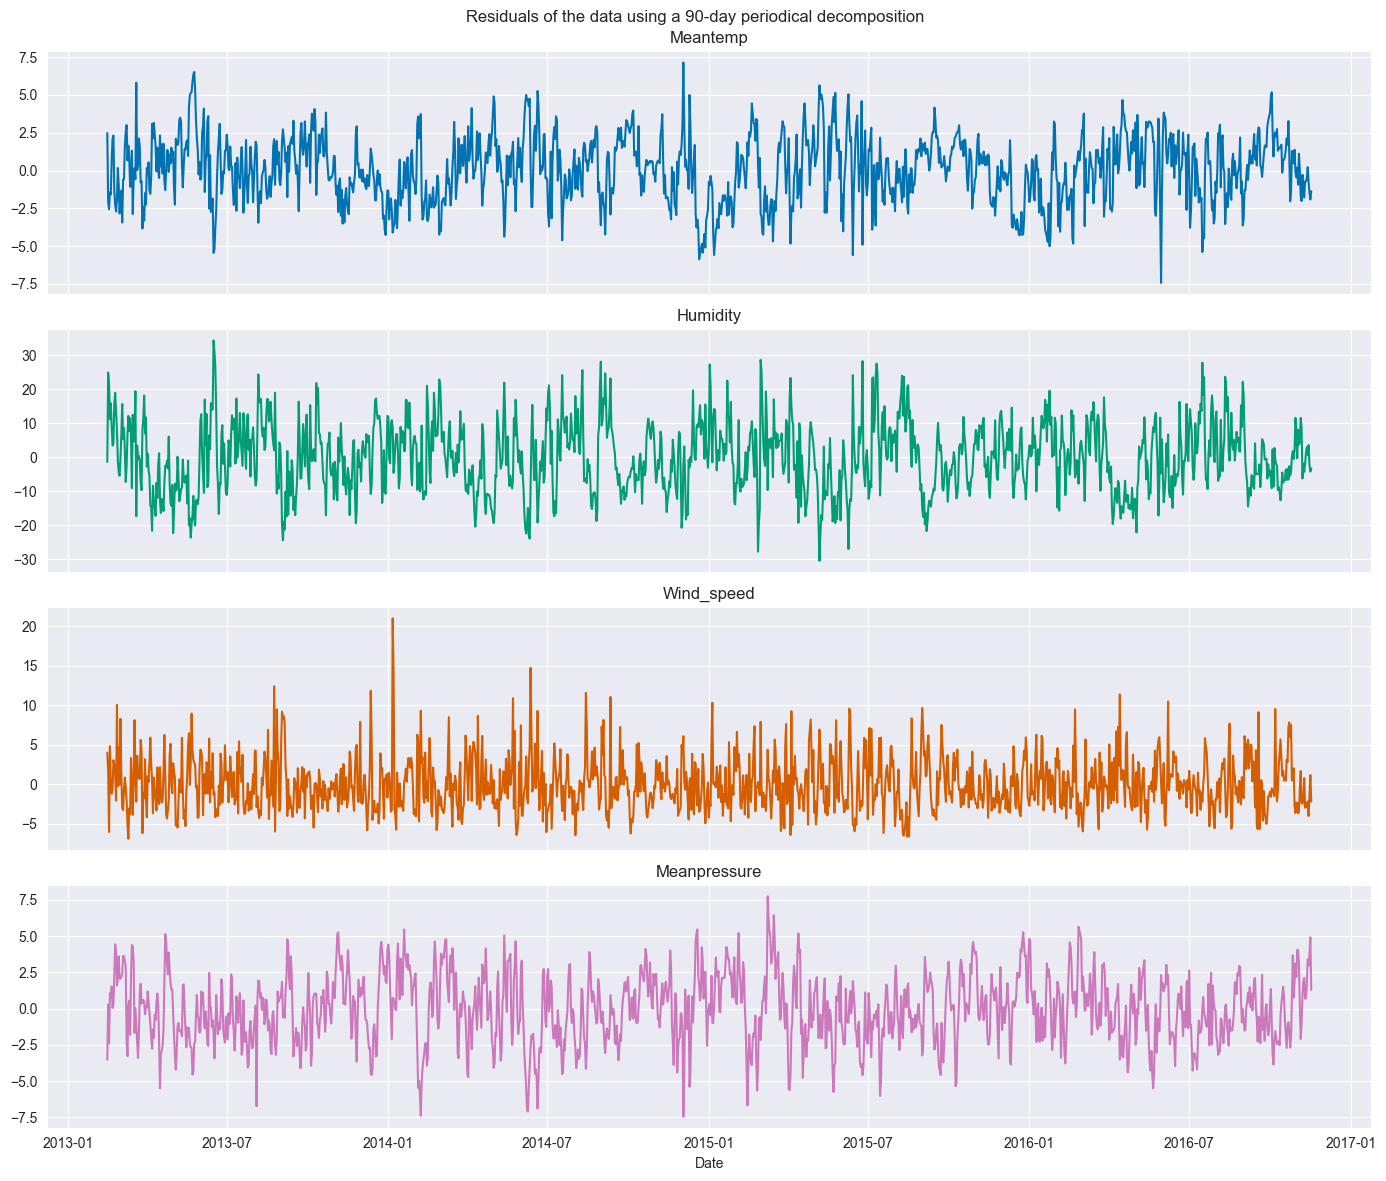

In [147]:
figure, axes = plt.subplots(
    len(decomps), 1, figsize=(14, 12), sharex=True
)  # 4 rows, 1 column
for i, decomposition in enumerate(decomps):
    axes[i].plot(decomposition.resid, label="Trend", color=colors[i])
    axes[i].set_title(f"{df.columns[i+1].capitalize()}")

axes[-1].set_xlabel("Date")
figure.suptitle("Residuals of the data using a 90-day periodical decomposition")
plt.tight_layout()
plt.show()